In [1]:
from lightning.pytorch import Trainer
import lightning.pytorch as pl
from src.models.ndt1_wrapper import NDT1SSLModule
from src.data.spike_datamodule import SpikeDataModule
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from lightning.pytorch import seed_everything
from joblib import Parallel, delayed
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from itertools import product
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import pandas as pd
import pysindy as ps
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing.prp import add_perceived_probs
from experiments.PerNeuronImportance import PerNeuronImpartanceNDTFactorMLP
import sys
import src.models.ndt1_wrapper as real_mod
sys.modules['models.ndt1_wrapper'] = real_mod
pl.seed_everything(654)

# 128 D 2 L
# ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/346362216954362618/fa251add30e44cc7815c03d3494a4f74/artifacts/epoch=78-step=474/epoch=78-step=474.ckpt" # 0.52 / 0.55
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/fa251add30e44cc7815c03d3494a4f74/model-metrics


# 128 D 2 L
# ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/346362216954362618/ebc6eff0efee431e9563de6882b82912/artifacts/epoch=79-step=480/epoch=79-step=480.ckpt" # 0.79 / 0.63
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/ebc6eff0efee431e9563de6882b82912

# 128 D 2 L offdiag_cov_penalty
# ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/346362216954362618/2bb1b2dcc0d4497191079bdbc1ddbb1e/artifacts/epoch=115-step=696/epoch=115-step=696.ckpt" # 0.66 / 0.65
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/585cdfc5ff164538b43dc0e8eb9fe756/artifacts

# 128 D 2 L factor_vae_tc_10%
# ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/346362216954362618/1d4424770905483e934aac3a902eac85/artifacts/epoch=473-step=3301/epoch=473-step=3301.ckpt" # 0.87 / 0.65
# ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/346362216954362618/3b45848b055f44f2bb8c76fa8df7a6cd/artifacts/epoch=65-step=663/epoch=65-step=663.ckpt" # 0.87 / 0.65
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/585cdfc5ff164538b43dc0e8eb9fe756/artifacts

# 128 D 6 L
# ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/346362216954362618/acbe2be68a64451a88cbd2f5dcf8d20c/artifacts/epoch=56-step=342/epoch=56-step=342.ckpt" # 0.68 /0.48
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/acbe2be68a64451a88cbd2f5dcf8d20c/model-metrics

# 128 D 6 L
# ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/346362216954362618/5352b37ababa4479969dcd947680a4b2/artifacts/epoch=43-step=264/epoch=43-step=264.ckpt" # 0.65 / 0.62
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/346362216954362618/runs/5352b37ababa4479969dcd947680a4b2         

# 16 D 6 L
# ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/291913350782972063/2bafaf059f0b4472a8ea88d7c2cac5a9/artifacts/epoch=27-step=168/epoch=27-step=168.ckpt" # 0.6 /0.57
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/291913350782972063/runs/2bafaf059f0b4472a8ea88d7c2cac5a9/model-metrics         

# 16 D 6 L PRPD_W = 0
# ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/291913350782972063/b30b09947ace4c58a16edf93ed2ac397/artifacts/last/last.ckpt" # 0.6 /0.57
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/291913350782972063/runs/2bafaf059f0b4472a8ea88d7c2cac5a9/model-metrics         

# 128 D 2 L masker fix
ckpt_path = "D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/251540909251563445/2fea8f4f59054b44b7fc1d65dceacf79/artifacts/epoch=78-step=474/epoch=78-step=474.ckpt" # 0.65 /0.6481
# https://lx619lhl-5000.euw.devtunnels.ms/#/experiments/251540909251563445/runs/2fea8f4f59054b44b7fc1d65dceacf79      

session = "data/processed/spikes.npz"
prpd = "data/processed/prpd.npz"

spikes = np.load(session)["arr_0"] * 5
prpd = np.load(prpd)["arr_0"]
prpd[1:] = prpd[:-1]

full_ds = SpikeDataModule(   
    session_path = 'C:/Users/qf1824/Desktop/coding/Arseniis_Msc_proj/data/processed/spikes.npz',
    prpd_path = 'C:/Users/qf1824/Desktop/coding/Arseniis_Msc_proj/data/processed/prpd.npz',
    batch_size = 24,
    num_workers = 0,
    contrastive = False,
    fr_scale = False,
    max_spikes = 5,
    shift_prpd_by_one = True,
    )
full_ds.setup()
loader = full_ds.val_dataloader()

model = NDT1SSLModule.load_from_checkpoint(ckpt_path, map_location="cuda:0")
model.eval()

trainer = Trainer(
            accelerator="gpu",
            devices=1,
            logger=False,
            enable_checkpointing=False,
            max_epochs=1
         )

# metrics = trainer.validate(model, dataloaders=loader, verbose=False)[0]
metrics = trainer.validate(model, dataloaders=full_ds, verbose=False)[0]

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

c:\Users\qf1824\.local\share\mamba\envs\my_msc_proj\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\qf1824\.local\share\mamba\envs\my_msc_proj\lib\site-packages\cebra\integrations\sklearn\cebra.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Seed set to 654
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. F

Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Loading `train_dataloader` to estimate number of stepping batches.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]
val/loss/mlm: 0.1946
val/loss/prpd: 0.0921
val/loss/tc: 0.0170
val/prpd_r2: 0.6481
val/loss/total: 0.0471


In [2]:
model.hparams

"d_lr":                  5.849348540938728e-05
"d_phase_mb":            64
"d_phase_passes":        1
"d_pool_max":            256
"d_train_when_dloss_gt": 0.55
"d_update_every":        4
"latent_dim":            128
"lr_scheduler_args":     LrSchedulerArgs(max_lr=0.001, pct_start=0.15, div_factor=10.0)
"method_name":           ssl
"mlm_weight":            0.1
"ndt_cfg":               NdtConfig(encoder=EncoderConfig(from_pt=None, stitching=False, masker=MaskerConfig(force_active=True, mode='temporal', ratio=0.3, zero_ratio=1.0, random_ratio=1.0, expand_prob=0.0, max_timespan=1, channels=None, timesteps=None, mask_regions=['all'], target_regions=['all'], n_mask_regions=1), context=ContextConfig(forward=-1, backward=-1), norm_and_noise=NormAndNoiseConfig(active=False, smooth_sd=2.0, norm='zscore', eps=1e-07, white_noise_sd=1.0, constant_offset_sd=0.2), embedder=EmbedderConfig(n_channels=367, n_blocks=12, n_dates=1, use_prompt=False, use_session=False, max_F=80, mode='linear', mult=2, ada

In [3]:
seed_everything(42)

model.to("cuda")
model.eval()
model.ndt.encoder.masker.mode = 'temporal'
model.ndt.encoder.masker.ratio = 0

spike_tensor = torch.as_tensor(spikes, dtype=torch.float32)
dataset = TensorDataset(spike_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

all_latents = []
with torch.no_grad():
    for (x,) in loader:
        print(x.size())
        x = x.to("cuda")
        z = model(x).latents.mean(dim=1)
        all_latents.append(z.cpu())

latents = torch.cat(all_latents).numpy()
latents.shape

Seed set to 42


torch.Size([32, 80, 367])
torch.Size([32, 80, 367])
torch.Size([32, 80, 367])
torch.Size([32, 80, 367])
torch.Size([32, 80, 367])
torch.Size([32, 80, 367])
torch.Size([32, 80, 367])
torch.Size([17, 80, 367])


(241, 128)

In [4]:
N_REPEATS = 10000
N_SPLITS = 5
ALPHA = 1e-3
N_JOBS = -1

D = latents.shape[1]
all_r2 = np.empty(N_REPEATS)
select = np.zeros((N_REPEATS, D), int)
weights = np.zeros((N_REPEATS, D))

def one_repeat(seed):
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
    r2_accum = []
    nonzero = np.zeros(D, bool)
    weight = np.zeros(D)

    for train_idx, val_idx in kf.split(latents):
        z_tr, z_val = latents[train_idx], latents[val_idx]
        y_tr, y_val = prpd[train_idx],    prpd[val_idx]

        clf = Lasso(alpha=ALPHA, max_iter=1000)
        clf.fit(z_tr, y_tr)

        y_pred = clf.predict(z_val)
        r2_accum.append(r2_score(y_val, y_pred))

        sel = clf.coef_ != 0.0
        nonzero = nonzero | sel
        weight += np.abs(clf.coef_)

    return (np.mean(r2_accum), nonzero.astype(int), weight / N_SPLITS)


results = Parallel(n_jobs=N_JOBS, verbose=False)(
    delayed(one_repeat)(seed) for seed in range(N_REPEATS)
)

for i, (r2, nz, w) in enumerate(results):
    all_r2[i] = r2
    select[i] = nz
    weights[i] = w

print(f"mean R2 +/- SD: {all_r2.mean():.4f} +/- {all_r2.std(ddof=1):.4f}")
print(f"median R2: {np.median(all_r2):.4f}")

freq = select.mean(axis=0)
mean_abs_w = np.where(freq>0, weights.sum(axis=0)/select.sum(axis=0), 0.)

important = np.argsort(-mean_abs_w)[:10]
print("\nTop 10 latent dimensions by stability:")
for idx in important:
    print(f" dim {idx:2d} freq={freq[idx]:.3f} w={mean_abs_w[idx]:.4f}")

mean R2 +/- SD: 0.9145 +/- 0.0028
median R2: 0.9149

Top 10 latent dimensions by stability:
 dim 14 freq=1.000 w=0.2827
 dim 101 freq=1.000 w=0.1510
 dim  2 freq=1.000 w=0.1375
 dim 58 freq=0.998 w=0.0742
 dim  8 freq=0.922 w=0.0299
 dim 83 freq=0.999 w=0.0286
 dim 76 freq=0.638 w=0.0237
 dim 22 freq=0.238 w=0.0186
 dim 75 freq=0.768 w=0.0156
 dim 53 freq=0.126 w=0.0138


C:\Users\qf1824\AppData\Local\Temp\ipykernel_18676\2403074469.py:47: RuntimeWarning: invalid value encountered in divide
  mean_abs_w = np.where(freq>0, weights.sum(axis=0)/select.sum(axis=0), 0.)


In [5]:
(-mean_abs_w).argsort()

array([ 14, 101,   2,  58,   8,  83,  76,  22,  75,  53,  16,   6,  81,
        90, 113,  97,  82,  84,  23, 111,  79, 116,  72,  43, 114,   3,
        60,  32, 103,  50,  41,  45, 124,  21,  56,   4,  88,  66,   9,
        46,  78, 110,  92,  99,   7, 120, 108,  96,  15,  69,  54,  30,
        39,  28,  62, 117,   1,  87,  86,  85,  91,  89,   0,  94, 125,
       123, 122, 121, 119, 118, 115,  93, 112, 107, 106, 105, 102, 100,
        98,  95, 109, 104,  63,  77,  36,  35,  34,  33,  31,  29,  27,
        26,  25,  24,  20,  19,  18,  17,  13,  12,  11,  10,   5,  37,
        80,  38,  42,  74,  73,  71,  70,  68,  67,  65,  64, 126,  61,
        59,  57,  55,  52,  51,  49,  48,  47,  44,  40, 127], dtype=int64)

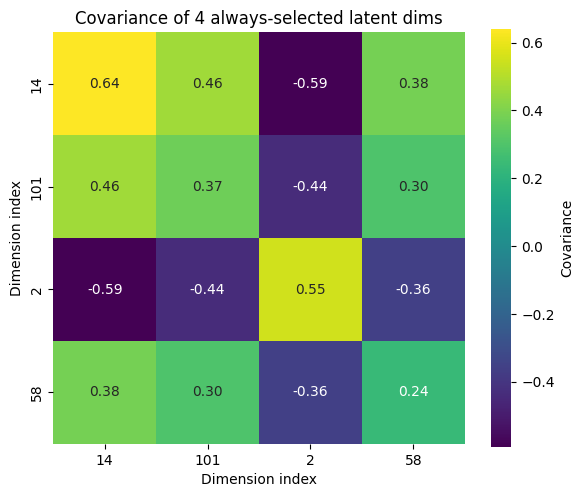

In [6]:
idx=(-mean_abs_w).argsort()[:4]
lat_sub = latents[:, idx] 
cov = np.cov(lat_sub, rowvar=False)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cov,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "Covariance"},
    square=True,
    xticklabels=idx,
    yticklabels=idx,
)
plt.title(f"Covariance of {len(idx)} always-selected latent dims")
plt.xlabel("Dimension index")
plt.ylabel("Dimension index")
plt.tight_layout()
plt.show()

In [7]:
idx = (-mean_abs_w).argsort()[:4]
sel_z = latents[:,idx]
sel_z.shape, idx

((241, 4), array([ 14, 101,   2,  58], dtype=int64))

In [8]:
idx = [ 14, 101,   2,  58]

In [9]:
droot = Path('C:/Users/qf1824/Desktop/coding/Arseniis_Msc_proj/data/JPAS_0023_20230922')
bp = droot/'BEHAV'

with open(bp/'metrics.json') as f:
    behav = json.load(f)
metrics = behav['metrics']
trials = pd.DataFrame(metrics['trials'])
INIT_PRP = 0.5
trials = add_perceived_probs(trials, init_p=INIT_PRP)
trials.shape

(258, 15)

In [10]:

sort_idx = (-mean_abs_w).argsort()

Z = latents[:,sort_idx]
y = prpd
cv = KFold(n_splits=10, shuffle=True, random_state=0)


r2_single = []
for k in range(Z.shape[1]):
    r2_k = cross_val_score(
        Ridge(alpha=1.0),
		Z[:, k][:, None],
  		y,
		cv=cv, scoring='r2'
  	).mean()
    r2_single.append(r2_k)

order = np.argsort(r2_single)[::-1]
cum_r2 = np.cumsum(np.array(r2_single)[order])

print("Top dims & marginal R2:")
for i, idx in enumerate(order[:5]):
    print(f"  dim{idx}: {r2_single[idx]:.2f}")

print(f"Cumulative R2 after 5 dims = {cum_r2[-1]:.2f}")
cum_r2

Top dims & marginal R2:
  dim7: 0.91
  dim9: 0.91
  dim2: 0.91
  dim75: 0.91
  dim84: 0.91
Cumulative R2 after 5 dims = 65.70


array([ 0.90955904,  1.81885859,  2.72799115,  3.63662216,  4.54334172,
        5.45003165,  6.35558103,  7.2604851 ,  8.16406631,  9.06638597,
        9.96717815, 10.86593438, 11.7645574 , 12.66298223, 13.5609741 ,
       14.45862379, 15.34964143, 16.2396526 , 17.12937394, 18.01851808,
       18.90346467, 19.78643399, 20.66053068, 21.53265578, 22.40212201,
       23.26997033, 24.13580071, 24.99530202, 25.85393651, 26.71000426,
       27.56526511, 28.41654195, 29.26267149, 30.09937717, 30.93368895,
       31.76494044, 32.59050511, 33.41488609, 34.22538039, 35.03277127,
       35.82968257, 36.62015997, 37.4105875 , 38.19504329, 38.97591957,
       39.75276908, 40.52251708, 41.28294612, 42.04014924, 42.79518858,
       43.54207087, 44.27080696, 44.99643612, 45.7171721 , 46.4301838 ,
       47.1319935 , 47.82938855, 48.50717095, 49.18107681, 49.8538914 ,
       50.51548261, 51.16456603, 51.81228571, 52.45597872, 53.07903211,
       53.68927907, 54.29364095, 54.8023956 , 55.26987407, 55.73

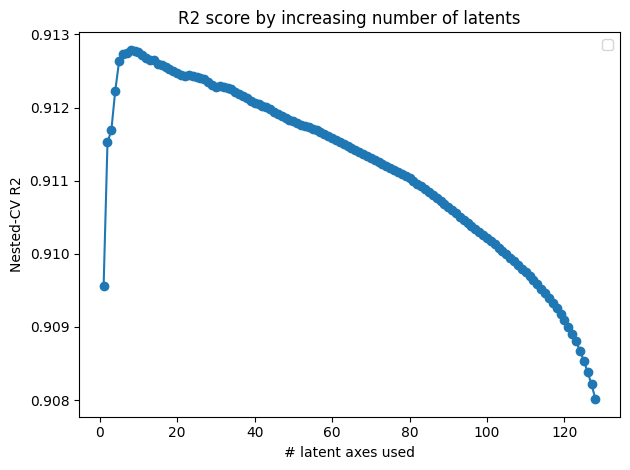

In [11]:
selected, inc_r2 = [], []
residual = y.copy()

for _ in range(Z.shape[1]):
    best_dim, best_r2 = None, -np.inf
    for k in range(Z.shape[1]):
        if k in selected: continue
        X = Z[:, [*selected, k]]
        r2_k = cross_val_score(Ridge(1.0), X, y, cv=cv, scoring='r2').mean()
        if r2_k > best_r2:
            best_dim, best_r2 = k, r2_k
    selected.append(best_dim)
    inc_r2.append(best_r2)
    
k = np.arange(1, len(inc_r2)+1)
plt.plot(k, inc_r2, marker='o')
plt.xlabel('# latent axes used')
plt.ylabel('Nested-CV R2')
plt.title('R2 score by increasing number of latents')
plt.legend();  plt.tight_layout();  plt.show()

In [12]:
trls = trials[~trials["set reward probabs l/r"].isna()].copy()[:241].reset_index()

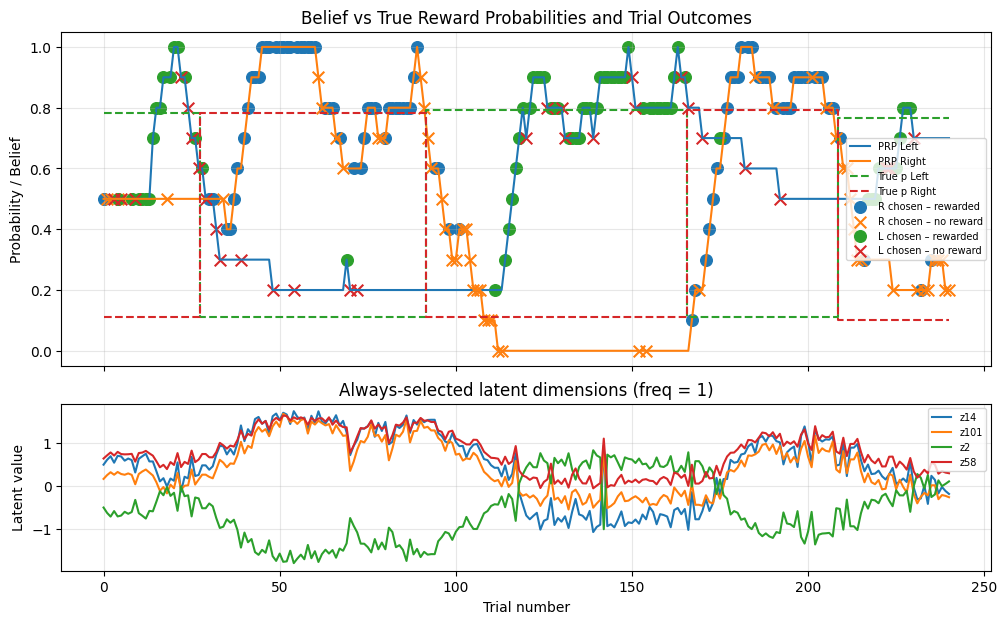

In [13]:
idx = [ 14, 101,   2,  58]
plt.close()
trls = trials[~trials["set reward probabs l/r"].isna()].copy()[:latents.shape[0]].reset_index()
trial_idx = trls.index

fig, (ax_belief, ax_z) = plt.subplots(
    2, 1, figsize=(12, 7), sharex=True,
    gridspec_kw={"height_ratios": [3, 1.5], "hspace": 0.15}
)

true_prob = np.array(trls["set reward probabs l/r"].tolist())
trls["true_pL"], trls["true_pR"] = true_prob[:, 0], true_prob[:, 1]

ax = ax_belief

ax.plot(trls.index, trls["PRPl"], label="PRP Left")
ax.plot(trls.index, trls["PRPr"], label="PRP Right")

ax.step(trls.index, trls["true_pL"],  linestyle="--", where="mid",
        label="True p Left")
ax.step(trls.index, trls["true_pR"],  linestyle="--", where="mid",
        label="True p Right")

right = trls["choice"].str.lower().eq("r")
left = trls["choice"].str.lower().eq("l")

ax.scatter(trls.index[right & trls["rewarded"]],
           trls.loc[right & trls["rewarded"], "PRPr"],
           marker="o", s=70, label="R chosen – rewarded")
ax.scatter(trls.index[right & ~trls["rewarded"]],
           trls.loc[right & ~trls["rewarded"], "PRPr"],
           marker="x", s=70, label="R chosen – no reward")

ax.scatter(trls.index[left & trls["rewarded"]],
           trls.loc[left & trls["rewarded"], "PRPl"],
           marker="o", s=70, label="L chosen – rewarded")
ax.scatter(trls.index[left & ~trls["rewarded"]],
           trls.loc[left & ~trls["rewarded"], "PRPl"],
           marker="x", s=70, label="L chosen – no reward")

# ax.set_xlabel("Trial number")
ax.set_ylabel("Probability / Belief")
ax.set_ylim(-0.05, 1.05)
ax.set_title("Belief vs True Reward Probabilities and Trial Outcomes")
ax.legend(fontsize=7, loc="right")
ax.grid(alpha=0.3)

color_cycle = plt.cm.tab10.colors

for d in range(4):
    # ax_z.plot(trial_idx, sel_z[:, d]+d,
    ax_z.plot(trial_idx, sel_z[:, d],
              label=f"z{idx[d]}", color=color_cycle[d % 10])

ax_z.set_ylabel("Latent value")
ax_z.set_xlabel("Trial number")
ax_z.set_title("Always-selected latent dimensions (freq = 1)")
ax_z.grid(alpha=0.3)
ax_z.legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

These latents in close look

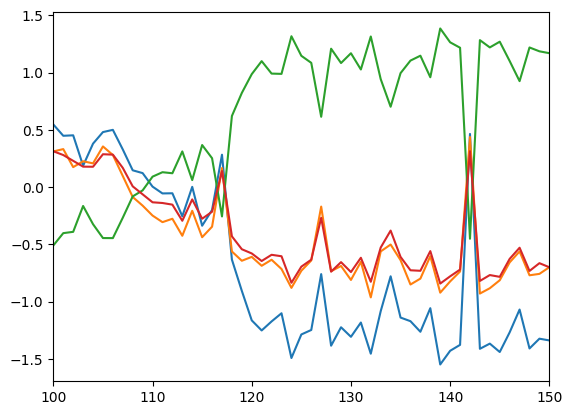

In [14]:
plt.plot(trial_idx, sel_z[:, 0]-sel_z[:, 0].mean(), color=color_cycle[0 % 10])
# # # plt.plot(trial_idx, sel_z[:, 1]*3-3.1, color=color_cycle[1 % 10])
plt.plot(trial_idx, sel_z[:, 1]-sel_z[:, 1].mean(), color=color_cycle[1 % 10])
plt.plot(trial_idx, sel_z[:, 2]-sel_z[:, 2].mean(), color=color_cycle[2 % 10])
plt.plot(trial_idx, sel_z[:, 3]-sel_z[:, 3].mean(), color=color_cycle[3 % 10])

# plt.plot(trial_idx, (sel_z[:, 0]-sel_z[:, 0].mean()) - (sel_z[:, 2]-sel_z[:, 2].mean()), color=color_cycle[4 % 10])
plt.xlim(100,150)
plt.show()

In [15]:
droot = Path('C:/Users/qf1824/Desktop/coding/Arseniis_Msc_proj/data/JPAS_0023_20230922')
dp = droot/'PHY_AK/uploaded_folder/JPAS_0023_20230922'
spike_clusters = np.load(dp/'spike_clusters.npy')
spike_times = np.load(dp/'spike_times_milliseconds_sync_to_behav.npy')
clust_qa = pd.read_csv(dp/'cluster_group.tsv', sep='\t')
good_unit_id = clust_qa[clust_qa.group=='good'].cluster_id.tolist()
good_units_mask = np.isin(spike_clusters, good_unit_id)

good_units = spike_clusters[good_units_mask]
good_times = spike_times[good_units_mask]

spike_df = pd.DataFrame({'unit': good_units, 'time_ms':good_times})

In [ ]:
BEHAV_LAG_MS = 200
WIN = 800  # ms
WIN_STEP = 400 # ms
BIN_MS = 10
normalizer = 1

units = np.sort(spike_df["unit"].unique())
unit2col = {u: i for i, u in enumerate(units)}
T = WIN//BIN_MS
n_units = units.shape[0]

n_units = len(units)
t_start = spike_df.time_ms.values[0]
t_end = spike_df.time_ms.values[-1]
n_windows = int((t_end-t_start-WIN)//WIN_STEP + 1)

spike_tensor = np.zeros((n_windows, T, n_units), dtype=np.uint8)

times = []
latents = []
i = 0

while (t_start+WIN) < t_end:
    t_start_ms = t_start - BEHAV_LAG_MS
    t_end_ms = t_start + WIN - BEHAV_LAG_MS
    
    t = t_start + (WIN/2)
    times.append(t)

    m = (spike_df.time_ms.values >= t_start_ms) & \
        (spike_df.time_ms.values <  t_end_ms)
    sub = spike_df.loc[m]

    if sub.empty:
        continue

    bin_idx = ((sub.time_ms.values - t_start_ms) // BIN_MS).astype(np.int64)

    unit_idx = sub.unit.map(unit2col).values.astype(np.int64)
    
    np.add.at(spike_tensor, (i, bin_idx, unit_idx), 1)
    
    i+=1
    t_start+=WIN_STEP
    
spike_tensor = spike_tensor.astype(np.float32) / normalizer
spike_tensor.shape, spike_tensor.max()
times = np.array(times)

In [17]:
model.to("cuda")
model.eval()
model.ndt.encoder.masker.mode = 'temporal'

with torch.no_grad():
	x = torch.from_numpy(spike_tensor).to("cuda")
	z = model(x).latents.mean(dim=1)

latents = z.cpu().numpy()
latents.shape

(3498, 128)

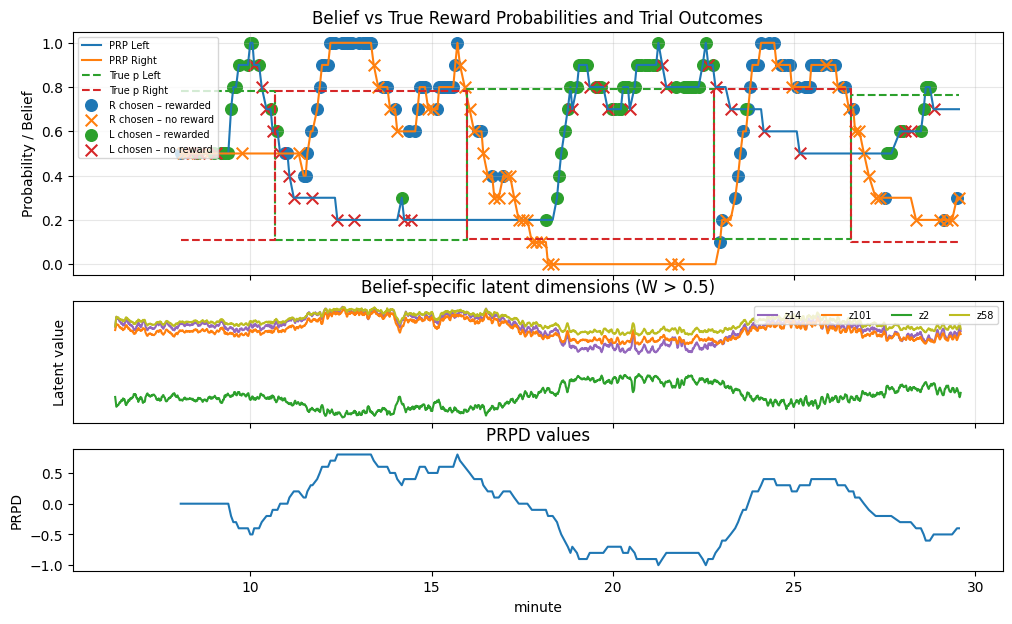

In [18]:
plt.close()
idx = [14, 101,   2,  58]
trls = trials[~trials["set reward probabs l/r"].isna()].copy()[:latents.shape[0]].reset_index()
trls['t_min'] = trls['t chosen'] / (1000*60)
t_min_latents = times/(1000*60)
trls = trls[trls.t_min <=(t_min_latents[-1])]


trial_idx = trls.index

fig, (ax_belief, ax_z, ax_prpd) = plt.subplots(
    3, 1, figsize=(12, 7), sharex=True,
    gridspec_kw={"height_ratios": [3, 1.5, 1.5], "hspace": 0.16}
)

true_prob = np.array(trls["set reward probabs l/r"].tolist())
trls["true_pL"], trls["true_pR"] = true_prob[:, 0], true_prob[:, 1]

ax = ax_belief

ax.plot(trls.t_min, trls["PRPl"], label="PRP Left")
ax.plot(trls.t_min, trls["PRPr"], label="PRP Right")

ax.step(trls.t_min, trls["true_pL"],  linestyle="--", where="mid",
        label="True p Left")
ax.step(trls.t_min, trls["true_pR"],  linestyle="--", where="mid",
        label="True p Right")

right = trls["choice"].str.lower().eq("r")
left = trls["choice"].str.lower().eq("l")

ax.scatter(trls.t_min[right & trls["rewarded"]],
           trls.loc[right & trls["rewarded"], "PRPr"],
           marker="o", s=70, label="R chosen – rewarded")
ax.scatter(trls.t_min[right & ~trls["rewarded"]],
           trls.loc[right & ~trls["rewarded"], "PRPr"],
           marker="x", s=70, label="R chosen – no reward")

ax.scatter(trls.t_min[left & trls["rewarded"]],
           trls.loc[left & trls["rewarded"], "PRPl"],
           marker="o", s=70, label="L chosen – rewarded")
ax.scatter(trls.t_min[left & ~trls["rewarded"]],
           trls.loc[left & ~trls["rewarded"], "PRPl"],
           marker="x", s=70, label="L chosen – no reward")

ax.set_ylabel("Probability / Belief")
ax.set_ylim(-0.05, 1.05)
ax.set_title("Belief vs True Reward Probabilities and Trial Outcomes")
ax.legend(fontsize=7, loc="upper left")
ax.grid(alpha=0.3)

color_cycle = plt.cm.tab10.colors

for i, id in enumerate(idx):
    ax_z.plot(t_min_latents, np.convolve(latents[:, id], np.ones(10)/10, mode='same')-(2.5 if i ==2 else 0),
    # # ax_z.plot(t_min_latents[80:-80], np.convolve(latents[:, id], np.ones(20)/20, mode='same')[80:-80] * (14 if i==3 else 1) - (12 if i==3 else 0),
    #           label=f"z{id}", color=color_cycle[id % 10])
    # ax_z.plot(t_min_latents, latents[:, id],
              label=f"z{id}", color=color_cycle[id % 10])

ax_z.set_ylabel("Latent value")
ax_z.set_yticks([])
ax_z.set_title("4 most ")
ax_z.grid(alpha=0.3)
ax_z.legend(ncol=5, fontsize=7, loc="upper right")
ax_z.set_title("Belief-specific latent dimensions (W > 0.5)")


ax_prpd.plot(trls.t_min, trls.PRPD)
ax_prpd.set_ylabel("PRPD")
ax_prpd.set_xlabel("minute")
ax_prpd.set_title("PRPD values")

plt.tight_layout()
plt.show()

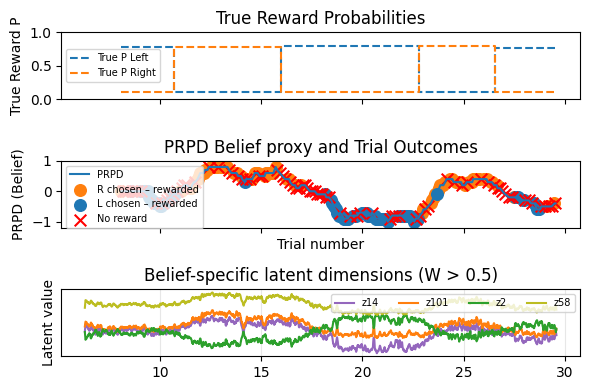

In [19]:
trls = trials[~trials["set reward probabs l/r"].isna()].copy()[:latents.shape[0]].reset_index()
trls['t_min'] = trls['t chosen'] / (1000*60)
t_min_latents = times/(1000*60)
trls = trls[trls.t_min <=(t_min_latents[-1])]

plt.close()
true_prob = np.array(trls["set reward probabs l/r"].tolist())
trls["true_pL"], trls["true_pR"] = true_prob[:, 0], true_prob[:, 1]

fig, (true_p_ax, prpd_ax, ax_z) = plt.subplots(nrows=3, figsize=(6, 4), sharex=True)

# ax.plot(trls.index, trls["PRPr"], label="PRP Right")

true_p_ax.step(trls.t_min, trls["true_pL"],  linestyle="--", where="mid", c='#1f77b4', label="True P Left")
true_p_ax.step(trls.t_min, trls["true_pR"],  linestyle="--", where="mid", c='#ff7f0e', label="True P Right")
true_p_ax.set_ylabel("True Reward P")

true_p_ax.set_ylim(0, 1)
true_p_ax.legend(fontsize=7)
# true_p_ax.set_xticks([])

right = trls["choice"].str.lower().eq("r")
left = trls["choice"].str.lower().eq("l")

prpd_ax.plot(trls.t_min, trls["PRPD"], label="PRPD")

prpd_ax.scatter(trls.t_min[right & trls["rewarded"]],
           trls.loc[right & trls["rewarded"], "PRPD"],
           marker="o", s=70, c='#ff7f0e', label="R chosen – rewarded")
prpd_ax.scatter(trls.t_min[left & trls["rewarded"]],
           trls.loc[left & trls["rewarded"], "PRPD"],
           marker="o", s=70, c='#1f77b4', label="L chosen – rewarded")


prpd_ax.scatter(trls.t_min[ ~trls["rewarded"]],
           trls.loc[~trls["rewarded"], "PRPD"],
           marker="x", s=70, c='red', label="No reward")

color_cycle = plt.cm.tab10.colors

for i, id in enumerate(idx):
    ax_z.plot(t_min_latents, np.convolve(latents[:, id], np.ones(10)/10, mode='same')+i/2,
              label=f"z{id}", color=color_cycle[id % 10])

ax_z.set_ylabel("Latent value")
ax_z.set_yticks([])
ax_z.set_title("4 most ")
ax_z.grid(alpha=0.3)
ax_z.legend(ncol=5, fontsize=7, loc="upper right")
ax_z.set_title("Belief-specific latent dimensions (W > 0.5)")


prpd_ax.set_xlabel("Trial number")
prpd_ax.set_ylabel("PRPD (Belief)")

true_p_ax.set_title("True Reward Probabilities")
prpd_ax.set_title("PRPD Belief proxy and Trial Outcomes")
prpd_ax.legend(fontsize=7, loc='upper left')
prpd_ax.set_ylim(-1.2, 1)
# ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Are z2 and z14 the same?

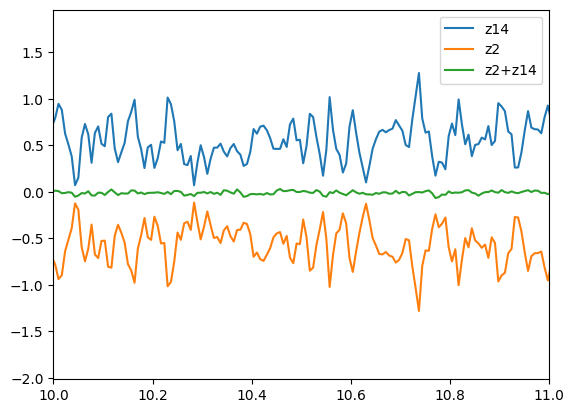

In [20]:
plt.plot(t_min_latents, latents[:,14], label='z14')
plt.plot(t_min_latents, latents[:,2], label='z2')
plt.plot(t_min_latents, latents[:,14]+latents[:,2], label='z2+z14')
plt.xlim(10,11)
plt.legend()

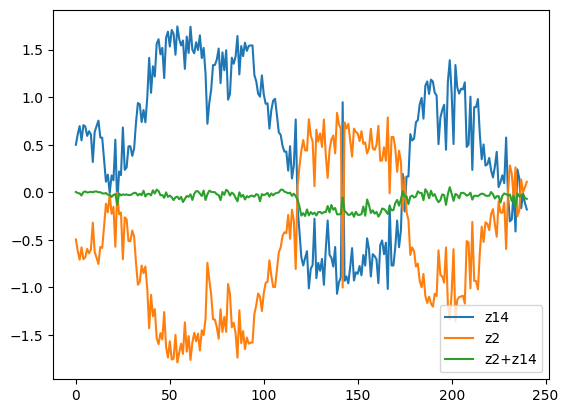

In [21]:
trial_idx.shape, sel_z.shape
plt.plot(sel_z[:,0], label='z14')
plt.plot(sel_z[:,2], label='z2')
plt.plot(sel_z[:,0]+sel_z[:,2], label='z2+z14')
plt.legend()

Compute Vanila saliency maps

In [22]:
model.eval()
per_n_saliency = PerNeuronImpartanceNDTFactorMLP(model)

x = torch.from_numpy(spike_tensor).to('cuda')
neuron_cams, preds = per_n_saliency(x)

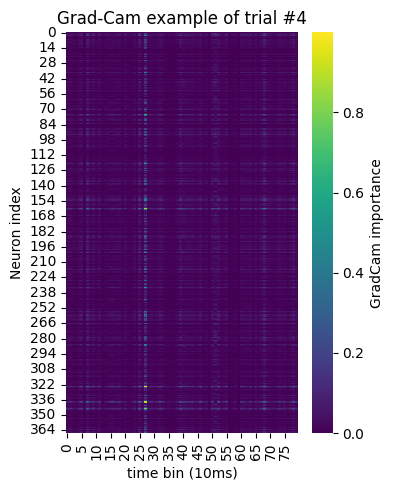

In [23]:
plt.figure(figsize=(4, 5))
sns.heatmap(
    neuron_cams.cpu().numpy()[4],
    cmap="viridis",
    cbar_kws={"label": "GradCam importance"},
)
plt.title(f"Grad-Cam example of trial #4")
plt.xlabel("time bin (10ms)")
plt.ylabel("Neuron index")
plt.tight_layout()
plt.show()

In [24]:
prpd_preds = preds.cpu().numpy()
f'Prpd min: {prpd_preds.min()}, max: {prpd_preds.max()}, mean: {prpd_preds.mean()}'

'Prpd min: -1.146193265914917, max: 0.9146713614463806, mean: -0.10770761221647263'

871 2214 663


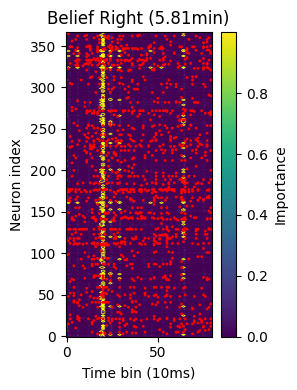

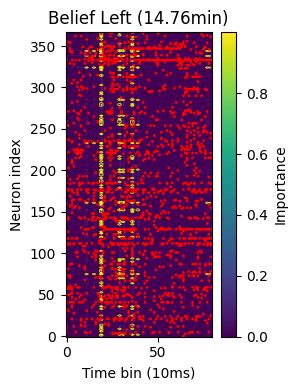

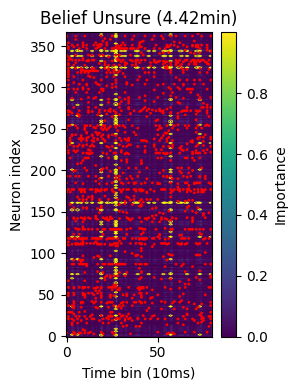

In [25]:
prpd_min, prpd_max, prpd_0 = np.argmax(prpd_preds), np.argmin(prpd_preds), np.argmin(np.abs(prpd_preds))
print(prpd_min, prpd_max, prpd_0)

for window_n, prpd_val in [[prpd_min,'Belief Right'],[prpd_max,'Belief Left'],[prpd_0,'Belief Unsure']]:
	saliency = neuron_cams.cpu().numpy()[window_n].T  
	spikes = spike_tensor[window_n]

	# threshold saliency by 99 percentile
	percentile = 99
	threshold = np.percentile(saliency, percentile)
	saliency_thresh = saliency.copy()
	saliency_thresh[saliency_thresh < threshold] = 0

	fig, ax = plt.subplots(figsize=(3, 4))
	# heatmap of raw saliency
	im = ax.imshow(saliency.T,
		aspect='auto',
		origin='lower',
		cmap='viridis',
		# alpha=0.75,
		zorder=0)
	# overlay saliency contours
	contour = ax.contour(
		saliency_thresh.T,
		levels=5,
		colors='yellow',
		linewidths=0.5,
		zorder=1
	)
	# scatter spikes 
	ax.set_ylabel('Neuron index')
	ax.set_xlabel('Time bin (10ms)')
	ax.set_title(f'{prpd_val} ({window_n*(0.4/60):.2f}min)')
	plt.colorbar(im, ax=ax, label='Importance')
	ys, xs = np.where(spikes.T > 0)
	ax.scatter(xs, ys,
            s=4,
			c='red',
			marker='o',
			edgecolors='none',
			zorder=2
		)
	plt.tight_layout()
	plt.show()

PRPD prediction over entire session

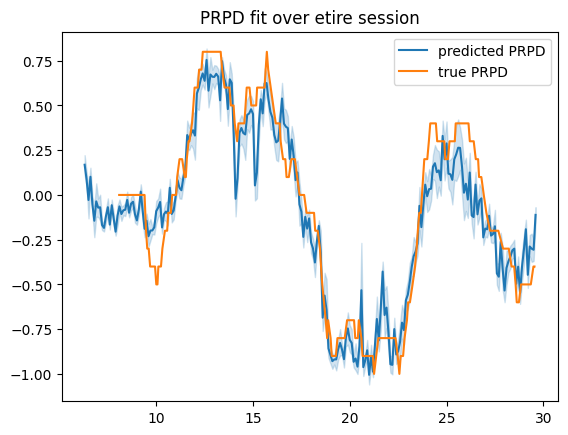

In [26]:
sns.lineplot(x=t_min_latents.round(1), y=preds.cpu().numpy(), label="predicted PRPD")
plt.plot(trls.t_min, trls["PRPD"], label="true PRPD")
plt.legend()
plt.title('PRPD fit over etire session')
plt.show()

In [27]:
neuron_cams_numpy = neuron_cams.cpu().numpy()

percentile = 99
saliency_thresholded = neuron_cams_numpy.copy()
threshold = np.percentile(neuron_cams_numpy, percentile, axis=(1,2))
threshold = (np.ones(neuron_cams_numpy.shape)*threshold.reshape((-1,1,1)))

saliency_thresholded[saliency_thresholded < threshold] = 0

neuron_activity = saliency_thresholded.sum(axis=(0, 2))

# top 100 most active neurons
topk = 100
most_active_indices = np.argsort(-neuron_activity)


Text(0.5, 1.0, 'z scored thresholded saliency distribution')

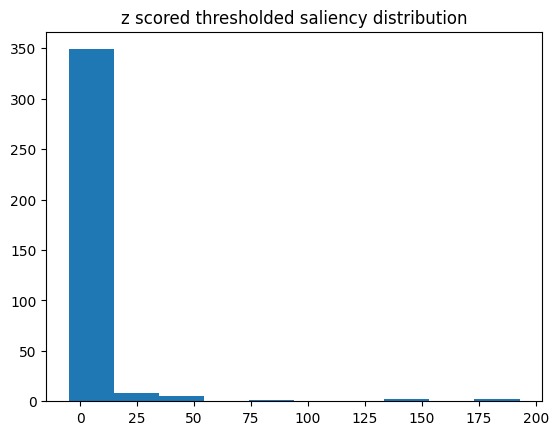

In [28]:
# shuffle by trial axis
shuffled = np.random.permutation(saliency_thresholded.reshape(-1, saliency_thresholded.shape[1])).reshape(saliency_thresholded.shape)

# shuffled control
shuffled_activity = np.sum(shuffled, axis=(0, 2))

# compare actual activity vs. shuffled baseline
z_scores = (neuron_activity - shuffled_activity.mean()) / (shuffled_activity.std() + 1e-6)
                                                       
plt.hist(z_scores)
plt.title('z scored thresholded saliency distribution')

In [29]:
z_scored = np.argwhere(z_scores > 2).reshape(-1)
z_scored.shape, z_scored

((42,),
 array([  2,  25,  36,  70,  75,  76,  83,  93, 120, 124, 126, 135, 138,
        139, 152, 153, 161, 162, 186, 191, 198, 201, 217, 227, 233, 244,
        255, 258, 259, 260, 266, 279, 285, 286, 324, 325, 332, 338, 344,
        345, 363, 366], dtype=int64))

Overlapping neurons with preliminary data analysis idenified ones

In [30]:
z_scored = np.array([  2,  25,  36,  70,  75,  76,  83,  93, 120, 124, 126, 135, 138,
        139, 152, 153, 161, 162, 186, 191, 198, 201, 217, 227, 233, 244,
        255, 258, 259, 260, 266, 279, 285, 286, 324, 325, 332, 338, 344,
        345, 363, 366])
ridge_w_gt_0_ground_truth = [
   0,   2,   4,  11,  12,  14,  15,  18,  19,  25,  30,  36,  39,  41,  48,  52,  58,  62,
  63,  64,  67,  70,  71,  73,  74,  75,  76,  78,  79,  86,  89,  91,  93,  96, 101, 103,
 105, 106, 108, 116, 117, 119, 120, 124, 126, 127, 132, 135, 137, 138, 141, 143, 145, 146,
 149, 150, 153, 154, 155, 157, 160, 161, 163, 164, 165, 167, 169, 172, 175, 183, 186, 188,
 195, 196, 197, 198, 199, 201, 202, 204, 205, 207, 213, 217, 219, 222, 223, 224, 230, 231,
 233, 234, 235, 239, 245, 247, 254, 256, 258, 259, 260, 261, 263, 269, 270, 282, 289, 292,
 295, 297, 300, 309, 311, 313, 314, 315, 321, 322, 323, 324, 325, 326, 327, 334, 337, 338,
 344, 345, 346, 348, 349, 350, 351, 352, 353, 354, 356, 357, 358, 360, 361, 363, 366]
lingress_p_l_005_ground_truth = [4, 5, 11, 14, 21, 22, 36, 38, 39, 41, 43, 47, 48, 49, 51, 52, 59, 62, 64, 69, 70, 74, 78, 83, 87, 93, 96, 97, 103, 112, 113, 114, 115, 124, 125, 126, 131, 132, 135, 138, 143, 153, 154, 157, 159, 160, 161, 164, 165, 166, 167, 168, 174, 177, 182, 183, 187, 193, 205, 208, 209, 211, 213, 215, 217, 219, 220, 221, 224, 227, 230, 232, 236, 238, 239, 242, 243, 244, 246, 247, 248, 252, 255, 256, 257, 259, 260, 264, 265, 266, 270, 276, 279, 281, 282, 285, 293, 295, 298, 303, 304, 307, 313, 315, 317, 321, 323, 324, 326, 327, 332, 333, 335, 337, 338, 339, 340, 341, 343, 344, 345, 346, 347, 348, 349, 353, 354, 359, 362, 363, 366]
np.isin(z_scored, ridge_w_gt_0_ground_truth).sum(), np.isin(z_scored, lingress_p_l_005_ground_truth).sum()


(29, 26)

Neurons agreed with CEBRA model

In [31]:
cebra_zscored_neurons = [ 50,  56,  69,  93,  96, 124, 138, 143, 167, 177, 205, 221, 224,
        239, 255, 272, 276, 295, 303, 304, 305, 310, 313, 315, 323, 328,
        332, 333, 337, 338, 345, 348, 353, 358]
overlapped_z_scored_neurons = np.isin(z_scored, cebra_zscored_neurons)
z_scored[overlapped_z_scored_neurons], overlapped_z_scored_neurons.sum()

(array([ 93, 124, 138, 255, 332, 338, 345]), 7)

In [32]:
overlapped_z_scored_neurons = np.array([93,124,138,255,332,338,345])
np.isin(overlapped_z_scored_neurons, ridge_w_gt_0_ground_truth).sum(), np.isin(overlapped_z_scored_neurons, lingress_p_l_005_ground_truth).sum()


(5, 7)

Plot those 7 neurons agreed between two models

Text(0.5, 0, 'min')

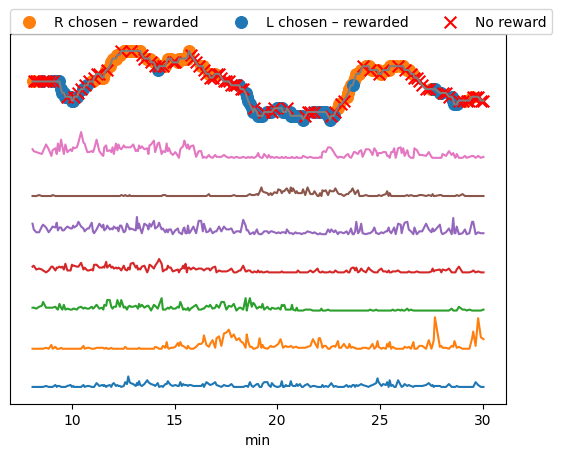

In [33]:
trials = pd.DataFrame(metrics['trials'])
INIT_PRP = 0.5
trials = add_perceived_probs(trials, init_p=INIT_PRP)
trials.shape
trls = trials[~trials["set reward probabs l/r"].isna()].copy()[:241].reset_index()
trls['t_min'] = trls['t chosen'] / (1000*60)

spikes = np.load(session)["arr_0"] * 5

overlapped_z_scored_neurons = [
    93, 124, 138, 255, 332, 338, 345,
]

scale_fr = 2
z_neurons_firing_rate = spikes[:,:,overlapped_z_scored_neurons].mean(axis=1)*scale_fr
z_neurons_firing_rate += np.arange(7).repeat(z_neurons_firing_rate.shape[0]).reshape((7,241)).T

shift_up = 8

plt.plot(trls.t_min, z_neurons_firing_rate)
plt.plot(trls.t_min, trls.PRPD+shift_up)

right = trls["choice"].str.lower().eq("r")
left = trls["choice"].str.lower().eq("l")

plt.scatter(trls.t_min[right & trls["rewarded"]],
           trls.loc[right & trls["rewarded"], "PRPD"]+shift_up,
           marker="o", s=70, c='#ff7f0e', label="R chosen – rewarded")
plt.scatter(trls.t_min[left & trls["rewarded"]],
           trls.loc[left & trls["rewarded"], "PRPD"]+shift_up,
           marker="o", s=70, c='#1f77b4', label="L chosen – rewarded")

plt.scatter(trls.t_min[ ~trls["rewarded"]],
           trls.loc[~trls["rewarded"], "PRPD"]+shift_up,
           marker="x", s=70, c='red', label="No reward")
plt.yticks([])
plt.legend(ncol=3, loc=(0,1))
plt.xlabel('min')

Try to fit PySINDy over polynomial up to 3rd degree with interactions library of functions

In [34]:
idx = [14, 101,   2,  58]
trls = trls[14:]
take_latents = times >= trls['t chosen'].values[0]
select_times = times[take_latents]
select_latents = latents[take_latents, :]
select_latents = select_latents[:, idx]

# interpolate prpd to match latents resolution
prpd_interp = np.interp(select_times, trls['t chosen'].values, trls.PRPD)
# smooth_latents = [np.convolve(select_latents[:, i], np.ones(80)/80, mode='same') for i in range(4)]
# X = np.column_stack([*smooth_latents, prpd_interp])
X = np.column_stack([select_latents, prpd_interp])
X.shape

(3018, 5)

In [35]:
dt = WIN_STEP/1000 # milliseconds to seconds
t = np.arange(X.shape[0])*dt

poly_library = ps.PolynomialLibrary(degree=3, include_interaction=True)
optimizer = ps.STLSQ(threshold=0.05, alpha=0.0)
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=poly_library,
    feature_names=[f"z{i+1}" for i in idx] + ["prpd"]
)

model.fit(X, t=dt)
model.print()

score = model.score(X, t=dt)
print(f"R2 on training data: {score:.3f}")

(z15)' = 39.636 1 + 132.419 z15 + 167.450 z102 + 123.400 z3 + -234.168 z59 + -6.469 prpd + 94.834 z15^2 + 334.315 z15 z102 + 112.863 z15 z3 + -537.440 z15 z59 + -7.457 z15 prpd + 230.640 z102^2 + 278.953 z102 z3 + -681.101 z102 z59 + -16.752 z102 prpd + -0.187 z3^2 + -518.457 z3 z59 + -2.043 z3 prpd + 459.459 z59^2 + 28.105 z59 prpd + 0.531 prpd^2 + -335.461 z15^3 + -126.514 z15^2 z102 + -1495.390 z15^2 z3 + -476.432 z15^2 z59 + 21.228 z15^2 prpd + 128.763 z15 z102^2 + -602.437 z15 z102 z3 + -815.228 z15 z102 z59 + 15.177 z15 z102 prpd + -2200.732 z15 z3^2 + -1056.865 z15 z3 z59 + 48.152 z15 z3 prpd + 471.770 z15 z59^2 + 7.680 z15 z59 prpd + -9.991 z15 prpd^2 + 95.882 z102^3 + 34.027 z102^2 z3 + -502.792 z102^2 z59 + -4.900 z102^2 prpd + -555.829 z102 z3^2 + -786.510 z102 z3 z59 + 30.135 z102 z3 prpd + 675.067 z102 z59^2 + 36.942 z102 z59 prpd + -1.940 z102 prpd^2 + -1074.880 z3^3 + -601.478 z3^2 z59 + 24.028 z3^2 prpd + 438.414 z3 z59^2 + -11.060 z3 z59 prpd + -13.875 z3 prpd^2 + -304

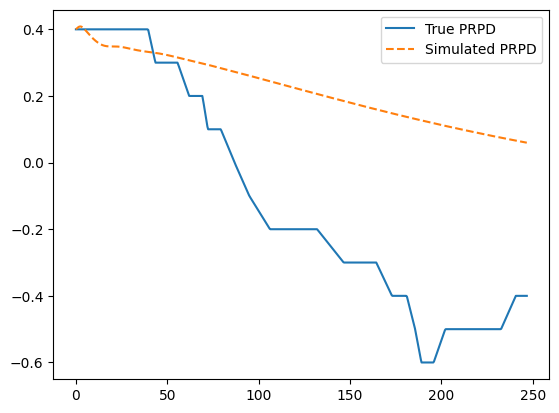

In [36]:
N=2400
X_train, X_test = X[:N], X[N:]
model.fit(X_train, t=dt)
X_sim = model.simulate(X_test[0], t[:len(X_test)])

plt.plot(t[:len(X_test)], X_test[:, -1], label="True PRPD")
plt.plot(t[:len(X_test)], X_sim[:, -1], "--", label="Simulated PRPD")
plt.legend()
plt.show()

In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)
split = int(0.8 * len(Xz))
X_train, X_test = Xz[:split], Xz[split:]

lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=False)
def fit_score(thr, alpha):
    base = ps.STLSQ(threshold=thr, alpha=alpha, normalize_columns=False)
    opt = ps.EnsembleOptimizer(
        opt=base,
        bagging=True, library_ensemble=True,
        n_models=20,
        n_subset=split,
    )
    model = ps.SINDy(
        feature_library=lib,
        optimizer=opt,
        feature_names=["z1","z2","z3","z4","prpd"],
        discrete_time=True,
    )
    model.fit(X_train)

    # one-step prediction R2 on train/test
    def r2(xa, xb):
        # xb - next-step ground truth
        Xhat = model.predict(xa[:-1])
        num = ((xb[1:] - Xhat)**2).sum()
        den = ((xb[1:] - xb[1:].mean(0))**2).sum()
        return 1 - num/den

    r2_tr = r2(X_train, X_train)
    r2_te = r2(X_test,  X_test)
    return model, r2_tr, r2_te

# search space
grid_thr = [0.05, 0.1, 0.2, 0.4]
grid_alph = [1e-3, 1e-2, 1e-1]

best = None
for thr, alpha in product(grid_thr, grid_alph):
    m, rtr, rte = fit_score(thr, alpha)
    comp = m.complexity
    score_tuple = (rte, -comp)
    if (best is None) or (score_tuple > best[0]):
        best = (score_tuple, (thr, alpha), (rtr, rte), m)

best_score, (thr, alpha), (r2_tr, r2_te), model = best
print(f"Best discrete SINDy: threshold={thr}, alpha={alpha}, R2_train={r2_tr:.3f}, R2_test={r2_te:.3f}, terms={model.complexity}")
model.print()

Best discrete SINDy: threshold=0.1, alpha=0.01, R2_train=0.912, R2_test=0.728, terms=62
(z1)[k+1] = -0.558 z2[k] + -0.580 z3[k] + 0.631 z4[k] + 0.294 prpd[k] + 0.992 z1[k]^2 + 0.235 z1[k] z3[k] + -0.826 z1[k] z4[k] + -0.811 z1[k] prpd[k] + -0.193 z2[k] z3[k] + -0.163 z2[k] z4[k] + 0.851 z3[k] z4[k] + -0.724 z3[k] prpd[k] + 0.946 z4[k]^2
(z2)[k+1] = -0.762 z1[k] + 0.163 z2[k] + -0.559 z3[k] + 0.690 z4[k] + 0.297 prpd[k] + -1.762 z1[k]^2 + 0.039 z1[k] z2[k] + -5.509 z1[k] z3[k] + -1.564 z1[k] z4[k] + -0.198 z1[k] prpd[k] + 0.156 z2[k]^2 + -0.779 z2[k] z3[k] + -1.118 z2[k] z4[k] + -3.440 z3[k]^2 + -0.276 z3[k] z4[k] + -0.034 z3[k] prpd[k] + 1.109 z4[k]^2 + 0.207 z4[k] prpd[k]
(z3)[k+1] = 0.230 z1[k] + 0.420 z2[k] + 0.691 z3[k] + -0.626 z4[k] + -0.289 prpd[k] + -0.737 z1[k]^2 + 0.924 z1[k] z4[k] + 0.370 z1[k] prpd[k] + 0.369 z2[k] z3[k] + 0.372 z2[k] z4[k] + -0.714 z3[k] z4[k] + 0.100 z3[k] prpd[k] + -0.938 z4[k]^2 + -0.219 z4[k] prpd[k]
(z4)[k+1] = -0.404 z1[k] + -0.341 z2[k] + -0.250 z3[

PRPD got dependent on itself, since it is just a proxy we remove it

In [38]:
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X[:,:4])
split = int(0.8 * len(Xz))
X_train, X_test = Xz[:split], Xz[split:]

lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=False)
def fit_score(thr, alpha):
    base = ps.STLSQ(threshold=thr, alpha=alpha, normalize_columns=False)
    opt = ps.EnsembleOptimizer(
        opt=base,
        bagging=True, library_ensemble=True,
        n_models=20,
        n_subset=split,
    )
    model = ps.SINDy(
        feature_library=lib,
        optimizer=opt,
        feature_names=["z1","z2","z3","z4"],
        discrete_time=True,
    )
    model.fit(X_train)

    def r2(XA, XB):
        Xhat = model.predict(XA[:-1])
        num = ((XB[1:] - Xhat)**2).sum()
        den = ((XB[1:] - XB[1:].mean(0))**2).sum()
        return 1 - num/den

    r2_tr = r2(X_train, X_train)
    r2_te = r2(X_test,  X_test)
    return model, r2_tr, r2_te

grid_thr = [0.05, 0.1, 0.2, 0.4]
grid_alph = [1e-3, 1e-2, 1e-1]

best = None
for thr, alpha in product(grid_thr, grid_alph):
    m, rtr, rte = fit_score(thr, alpha)
    comp = m.complexity
    score_tuple = (rte, -comp)
    if (best is None) or (score_tuple > best[0]):
        best = (score_tuple, (thr, alpha), (rtr, rte), m)

best_score, (thr, alpha), (r2_tr, r2_te), model = best
print(f"Best discrete SINDy: threshold={thr}, alpha={alpha}, R2_train={r2_tr:.3f}, R2_test={r2_te:.3f}, terms={model.complexity}")
model.print()

Best discrete SINDy: threshold=0.2, alpha=0.1, R2_train=0.873, R2_test=0.635, terms=28
(z1)[k+1] = 0.291 z1[k] + -0.490 z2[k] + -0.495 z3[k] + 0.617 z4[k] + -0.173 z2[k] z4[k] + 0.385 z3[k] z4[k] + 0.549 z4[k]^2
(z2)[k+1] = -0.650 z1[k] + 0.173 z2[k] + -0.576 z3[k] + 0.809 z4[k] + 0.380 z1[k] z2[k] + -0.464 z2[k] z4[k] + 0.688 z3[k] z4[k] + 0.790 z4[k]^2
(z3)[k+1] = 0.384 z2[k] + 0.645 z3[k] + -0.662 z4[k] + 0.193 z2[k] z4[k] + -0.332 z3[k]^2 + -0.994 z3[k] z4[k] + -0.846 z4[k]^2
(z4)[k+1] = -0.206 z2[k] + 1.135 z4[k] + 0.295 z1[k] z2[k] + -0.406 z2[k] z4[k] + 0.588 z3[k] z4[k] + 0.707 z4[k]^2


In [39]:
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X[:,(0,1,3)])
split = int(0.8 * len(Xz))
X_train, X_test = Xz[:split], Xz[split:]

lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=False)
def fit_score(thr, alpha):
    base = ps.STLSQ(threshold=thr, alpha=alpha, normalize_columns=False)
    opt = ps.EnsembleOptimizer(
        opt=base,
        bagging=True, library_ensemble=True,
        n_models=20,
        n_subset=split,
    )
    model = ps.SINDy(
        feature_library=lib,
        optimizer=opt,
        feature_names=["z1","z2","z3"],
        discrete_time=True,
    )
    model.fit(X_train)

    def r2(XA, XB):
        Xhat = model.predict(XA[:-1])
        num = ((XB[1:] - Xhat)**2).sum()
        den = ((XB[1:] - XB[1:].mean(0))**2).sum()
        return 1 - num/den

    r2_tr = r2(X_train, X_train)
    r2_te = r2(X_test,  X_test)
    return model, r2_tr, r2_te

grid_thr = [0.05, 0.1, 0.2, 0.4]
grid_alph = [1e-3, 1e-2, 1e-1]

best = None
for thr, alpha in product(grid_thr, grid_alph):
    m, rtr, rte = fit_score(thr, alpha)
    comp = m.complexity
    score_tuple = (rte, -comp)
    if (best is None) or (score_tuple > best[0]):
        best = (score_tuple, (thr, alpha), (rtr, rte), m)

best_score, (thr, alpha), (r2_tr, r2_te), model = best
print(f"Best discrete SINDy: threshold={thr}, alpha={alpha}, R2_train={r2_tr:.3f}, R2_test={r2_te:.3f}, terms={model.complexity}")
model.print()

Best discrete SINDy: threshold=0.2, alpha=0.001, R2_train=0.871, R2_test=0.646, terms=22
(z1)[k+1] = 0.668 z1[k] + -0.376 z2[k] + 0.622 z3[k] + 0.531 z1[k]^2 + 1.622 z1[k] z2[k] + -2.953 z1[k] z3[k] + 1.357 z2[k]^2 + -4.542 z2[k] z3[k] + 3.964 z3[k]^2
(z2)[k+1] = -0.195 z1[k] + 0.332 z2[k] + 0.778 z3[k] + 0.466 z1[k] z2[k] + -0.629 z1[k] z3[k] + -0.716 z2[k] z3[k] + 0.891 z3[k]^2
(z3)[k+1] = 0.926 z3[k] + 0.918 z1[k] z2[k] + -1.150 z1[k] z3[k] + 0.614 z2[k]^2 + -2.404 z2[k] z3[k] + 2.014 z3[k]^2


Trying to add 5th laten

In [40]:
idx = [14, 101,   2,  58, 8]
trls = trls[14:]
take_latents = times >= trls['t chosen'].values[0]
select_times = times[take_latents]
select_latents = latents[take_latents, :]
select_latents = select_latents[:, idx]

scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(select_latents)
split = int(0.8 * len(Xz))
X_train, X_test = Xz[:split], Xz[split:]

lib = ps.PolynomialLibrary(degree=2, include_interaction=True, include_bias=False)
def fit_score(thr, alpha):
    base = ps.STLSQ(threshold=thr, alpha=alpha, normalize_columns=False)
    opt = ps.EnsembleOptimizer(
        opt=base,
        bagging=True, library_ensemble=True,
        n_models=20,
        n_subset=split,
    )
    model = ps.SINDy(
        feature_library=lib,
        optimizer=opt,
        feature_names=["z1","z2","z3","z4","z5"],
        discrete_time=True,
    )
    model.fit(X_train)

    def r2(XA, XB):
        Xhat = model.predict(XA[:-1])
        num = ((XB[1:] - Xhat)**2).sum()
        den = ((XB[1:] - XB[1:].mean(0))**2).sum()
        return 1 - num/den

    r2_tr = r2(X_train, X_train)
    r2_te = r2(X_test,  X_test)
    return model, r2_tr, r2_te

grid_thr = [0.05, 0.1, 0.2, 0.4]
grid_alph = [1e-3, 1e-2, 1e-1]

best = None
for thr, alpha in product(grid_thr, grid_alph):
    m, rtr, rte = fit_score(thr, alpha)
    comp = m.complexity
    score_tuple = (rte, -comp)
    if (best is None) or (score_tuple > best[0]):
        best = (score_tuple, (thr, alpha), (rtr, rte), m)

best_score, (thr, alpha), (r2_tr, r2_te), model = best
print(f"Best discrete SINDy: threshold={thr}, alpha={alpha}, R2_train={r2_tr:.3f}, R2_test={r2_te:.3f}, terms={model.complexity}")
model.print()

Best discrete SINDy: threshold=0.4, alpha=0.1, R2_train=0.868, R2_test=0.589, terms=13
(z1)[k+1] = -0.779 z2[k] + -0.680 z3[k] + 1.021 z4[k]
(z2)[k+1] = -0.704 z1[k] + -0.474 z3[k] + 1.141 z4[k]
(z3)[k+1] = 0.534 z2[k] + 0.508 z3[k] + -0.956 z4[k]
(z4)[k+1] = 0.936 z4[k]
(z5)[k+1] = 1.223 z1[k] + 0.922 z3[k] + -1.191 z4[k]
